<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/NorthwesternHeader.png?raw=1">

#### MSDS422 Assignment 08:

Binary classification of movie reviews as positive or negative using the text of the review.
Large Movie Review Dataset. This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.

<div class="alert alert-block alert-success">
    <b>More Technical</b>: Throughout the notebook. This types of boxes provide more technical details and extra references about what you are seeing. They contain helpful tips, but you can safely skip them the first time you run through the code.
</div>


In [1]:
# Helper libraries
import datetime
from packaging import version
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from collections import Counter
import numpy as np
import pandas as pd

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN,LSTM
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Dropout, Flatten, Input, Dense
import tensorflow_datasets as tfds
#from plot_keras_history import plot_history

In [2]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

### Verify TensorFlow Version and Keras Version

In [3]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.3.0


In [4]:
print("Keras version: ", keras.__version__)

Keras version:  2.4.0


<div class="alert alert-block alert-info">
    <b>Suppress warning messages</b></div>

In [5]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

### Mount Google Drive to Colab Environment

In [6]:
#from google.colab import drive
#drive.mount('/content/gdrive')

In [7]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

### Download and Load IMDB dataset
<div class="alert alert-block alert-success">
This text classification tutorial trains a <b>RNN - Recurrent Neural Network</b><br><br>
https://developers.google.com/machine-learning/glossary/#recurrent_neural_network <br><br> <b>IMDB large movie review dataset</b><br>
http://ai.stanford.edu/~amaas/data/sentiment/) for sentiment analysis</div>

In [8]:
dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

  <div class="alert alert-block alert-info"> 
 The dataset `info` includes the encoder (a `tfds.features.text.SubwordTextEncoder`)</div>

In [9]:
encoder = info.features['text'].encoder

In [10]:
print('Vocabulary size: {}'.format(encoder.vocab_size))

Vocabulary size: 8185


#### This text encoder will reversibly encode any string, falling back to byte-encoding if necessary.

In [11]:
sample_string = 'Hello Northwestern Data Science Students.'

encoded_string = encoder.encode(sample_string)
print('Encoded string is {}'.format(encoded_string))

original_string = encoder.decode(encoded_string)
print('The original string: "{}"'.format(original_string))

Encoded string is [4025, 222, 4277, 4413, 878, 1848, 2675, 2975, 2509, 6623, 8044, 7975]
The original string: "Hello Northwestern Data Science Students."


In [12]:
assert original_string == sample_string

In [13]:
for index in encoded_string:
  print('{} ----> {}'.format(index, encoder.decode([index])))

4025 ----> Hell
222 ----> o 
4277 ----> North
4413 ----> western 
878 ----> Da
1848 ----> ta 
2675 ----> Sci
2975 ----> ence 
2509 ----> Stu
6623 ----> dent
8044 ----> s
7975 ----> .


### IMDB Reviews  - Label and Plain Text Review

### IMDB Reviews  - Label and Encoded Review 

<div class="alert alert-block alert-info"> 
<b>imdb_reviews</b><br>
https://www.tensorflow.org/datasets/catalog/imdb_reviews<br><br>
    FeaturesDict({<br>
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),<br>
    'text': Text(shape=(None,), dtype=tf.int64, encoder=<SubwordTextEncoder vocab_size=8185>),<br>
}) 
    
</div>

## Preprocess Data for Training

Next create batches of these encoded strings. Use the `padded_batch` method to zero-pad the sequences to the length of the longest string in the batch:

In [14]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [15]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE)

test_dataset = test_dataset.padded_batch(BATCH_SIZE)

## Create the model

<div class="alert alert-block alert-success">
Build a `tf.keras.Sequential` model and start with an embedding layer.  An embedding layer stores one vector per word. Next, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.<br>

This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense` layer<br>

A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input—and then to the next<br>

The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the output. This helps the RNN to learn long range dependencies</div>

<div class="alert alert-block alert-info">
    <b>tf.keras.layers.Bidirectional</b><br>
    https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional
    </div>

#### Bidirectional RNNs
<br>
For sequences other than time series (e.g. text), it is often the case that a RNN model can perform better if it not only processes sequence from start to end, but also backwards. For example, to predict the next word in a sentence, it is often useful to have the context around the word, not only just the words that come before it.
<br><br>
Keras provides an easy API for you to build such bidirectional RNNs: the keras.layers.Bidirectional wrapper.

<div class="alert alert-block alert-info">
    <b>tf.keras.layers.SimpleRNN</b><br>
    https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN
    </div>

In [16]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          523840    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               16512     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 548,673
Trainable params: 548,673
Non-trainable params: 0
_________________________________________________________________


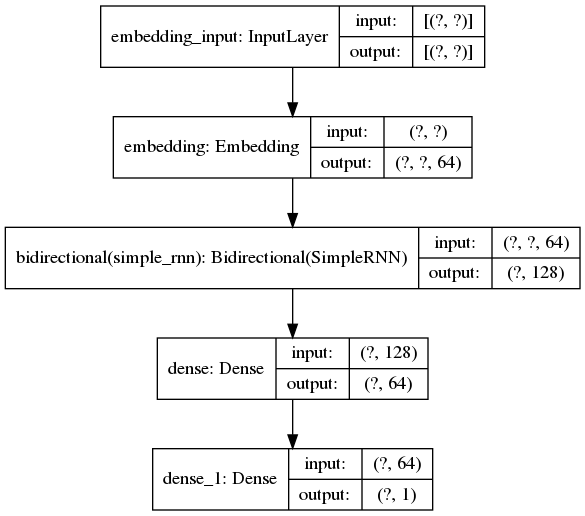

In [18]:
keras.utils.plot_model(model, "BinaryClassificationModel.png", show_shapes=True) 

<div class="alert alert-block alert-success"> 
Please note that we choose to Keras sequential model here since all the layers in the model only have single input and produce single output. </div>

<div class="alert alert-block alert-info"> 
<b>tf.keras.Model</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/Model
</div>    

## Compile Model 

In [19]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## Train the model

In [20]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset, 
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 305s 780ms/step - loss: 0.6959 - accuracy: 0.5004 - val_loss: 0.6930 - val_accuracy: 0.4917
Epoch 2/10
391/391 [==============================] - 308s 788ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6930 - val_accuracy: 0.4917
Epoch 3/10
391/391 [==============================] - 308s 788ms/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6929 - val_accuracy: 0.4917
Epoch 4/10
391/391 [==============================] - 310s 792ms/step - loss: 0.6911 - accuracy: 0.5021 - val_loss: 0.6922 - val_accuracy: 0.4927
Epoch 5/10
391/391 [==============================] - 307s 785ms/step - loss: 0.6620 - accuracy: 0.6066 - val_loss: 0.6399 - val_accuracy: 0.7406
Epoch 6/10
391/391 [==============================] - 311s 796ms/step - loss: 0.6025 - accuracy: 0.7887 - val_loss: 0.6439 - val_accuracy: 0.6385
Epoch 7/10
391/391 [==============================] - 313s 800ms/step - loss: 0.5712 - accuracy: 0.8512 - val_loss: 0.5936 -

## Test the model

In order to ensure that this is not a simple "memorization" by the machine, we should evaluate the performance on the test set. This is easy to do, we simply use the `evaluate` method on our model.

In [21]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 66s 169ms/step - loss: 0.5922 - accuracy: 0.8079
Test Loss: 0.5922377109527588
Test Accuracy: 0.8078799843788147


<div class="alert alert-block alert-info"> 
The above model does not mask the padding applied to the sequences.<br> This can lead to skew if trained on padded sequences and test on un-padded sequences<br>
<b>If the prediction is >= 0.5, it is positive else it is negative</b></div>

In [22]:
def pad_to_size(vec, size):
  zeros = [0] * (size - len(vec))
  vec.extend(zeros)
  return vec

In [23]:
def sample_predict(sample_pred_text, pad):
  encoded_sample_pred_text = encoder.encode(sample_pred_text)

  if pad:
    encoded_sample_pred_text = pad_to_size(encoded_sample_pred_text, 64)
  encoded_sample_pred_text = tf.cast(encoded_sample_pred_text, tf.float32)
  predictions = model.predict(tf.expand_dims(encoded_sample_pred_text, 0))

  return (predictions)

#### Prediction 1 RNN Model on a sample text without padding

In [24]:
sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print(predictions)

[[0.955]]


#### Prediction 2 RNN Model on a sample text with padding

In [25]:
sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)

[[0.131]]


In [26]:
#plot_history(history.history)
#plt.show()

## Plotting Performance Metrics 

We use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training)

In [27]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

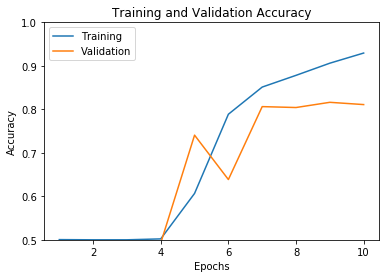

In [29]:
plt.plot(range(1, len(acc) + 1), history.history['accuracy'], label = 'Training')
plt.plot(range(1, len(val_acc) + 1), history.history['val_accuracy'], label = 'Validation')
plt.ylim([0.5, 1.0])
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

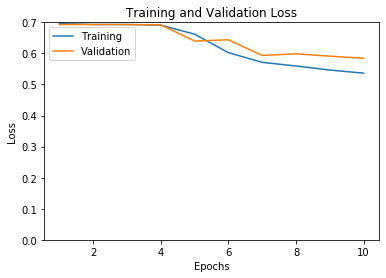

In [30]:
plt.plot(range(1, len(loss) + 1), history.history['loss'], label = 'Training')
plt.plot(range(1, len(val_loss) + 1), history.history['val_loss'], label = 'Validation')
plt.ylim([0.0, 0.7])
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Stack two or more LSTM layers

Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* Return either the full sequences of successive outputs for each timestep (a 3D tensor of shape `(batch_size, timesteps, output_features)`).
* Return only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)).

In [44]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [45]:
model2.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [46]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 64)          523840    
_________________________________________________________________
bidirectional_3 (Bidirection (None, None, 128)         66048     
_________________________________________________________________
bidirectional_4 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 635,329
Trainable params: 635,329
Non-trainable params: 0
________________________________________________

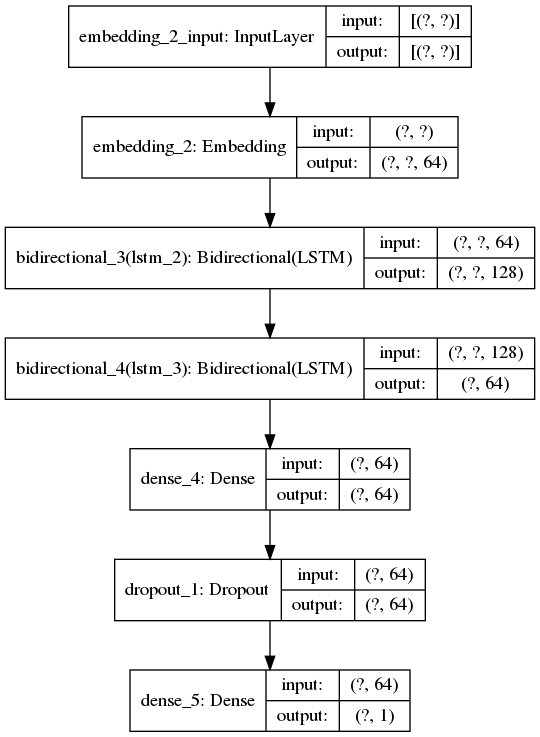

In [47]:
keras.utils.plot_model(model2, "LSTMBinaryClassificationModel.png", show_shapes=True) 

In [48]:
history2 = model2.fit(train_dataset, epochs=5,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/5
391/391 [==============================] - 1344s 3s/step - loss: 0.6837 - accuracy: 0.5076 - val_loss: 0.5846 - val_accuracy: 0.6531
Epoch 2/5
391/391 [==============================] - 1335s 3s/step - loss: 0.4303 - accuracy: 0.8076 - val_loss: 0.3985 - val_accuracy: 0.8250
Epoch 3/5
391/391 [==============================] - 1339s 3s/step - loss: 0.2865 - accuracy: 0.8928 - val_loss: 0.3527 - val_accuracy: 0.8474
Epoch 4/5
391/391 [==============================] - 1348s 3s/step - loss: 0.2351 - accuracy: 0.9164 - val_loss: 0.3423 - val_accuracy: 0.8661
Epoch 5/5
391/391 [==============================] - 1331s 3s/step - loss: 0.2001 - accuracy: 0.9309 - val_loss: 0.3523 - val_accuracy: 0.8667


In [49]:
test_loss, test_acc = model2.evaluate(test_dataset)
print('Test Accuracy: {}'.format(test_acc))
print('Test Loss: {}'.format(test_loss))

391/391 [==============================] - 328s 840ms/step - loss: 0.3527 - accuracy: 0.8595
Test Accuracy: 0.8595200181007385
Test Loss: 0.3526839315891266


#### Prediction 1 LSTM Model on a sample text without padding

In [50]:
sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print(predictions)

[[0.]]


#### Prediction 2 LSTM Model on a sample text with padding

In [51]:
sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)

[[0.]]


In [39]:
#plot_history(history.history)
#plt.show()

## Plotting Performance Metrics 

We use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training)

In [52]:
history_dict2 = history2.history
history_dict2.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [53]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

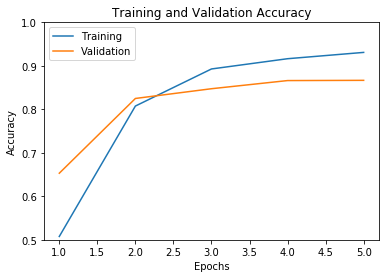

In [54]:
plt.plot(range(1, len(acc) + 1), history2.history['accuracy'], label = 'Training')
plt.plot(range(1, len(val_acc) + 1), history2.history['val_accuracy'], label = 'Validation')
plt.ylim([0.5, 1.0])
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

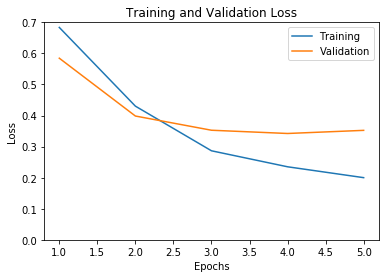

In [55]:
plt.plot(range(1, len(loss) + 1), history2.history['loss'], label = 'Training')
plt.plot(range(1, len(val_loss) + 1), history2.history['val_loss'], label = 'Validation')
plt.ylim([0.0, 0.7])
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()